# Information Propagation Analysis using Machine Learning

Can we use machine learning to better understand the propagation of information? Like ecosystems, information also reproduces, has niches, and is subject to selection pressures. When a piece of information on average propagates to more than one person, it tends to spread exponentially, or "goes viral". The spread of information is relevant everywhere, like when an organization is building a brand or spreading awareness of a new product. In this analysis we'll focus on scientific communication happening on twitter Machine Learning communities, to study which information is most likely to spread from one researcher to another.

Two main factors for us to think about are follower counts and niches. Accounts with lots of followers are naturally retweeted more often. In this project we can begin to quantify that relationship more specifically.

Niches are more complicated - the same tweet can go viral in one niche but not others. By specifically looking for "accounts connected to prominent machine-learning researchers" we can make the assumption that these will mostly represent a "machine learning" niche within the social network. This process would be different if we were studying virality in a pop music niche, for instance.

By learning about information propagation, we can gain a deeper insight into how markets work, how company culture forms, how insights propagate across teams, how misinformation spreads, and, generally, how change happens in social networks.

## Setup

In [197]:
# !pip install -U sentence-transformers
# !pip install pytorch
# !pip install pytorch-lightning
# !pip install typing-extensions --upgrade
# !pip install tensorboard
# !pip install pytorch-tabnet

# Standard Packages
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os
from pathlib import Path

# NLP Packages
from sentence_transformers import SentenceTransformer
from top2vec import Top2Vec

# ML Packages
from imblearn.over_sampling import SMOTE, SMOTENC
from xgboost import XGBClassifier
import xgboost
import statsmodels.api as sm
import torch
from pytorch_tabnet.tab_model import TabNetRegressor


from sklearn import metrics, model_selection, svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE, SequentialFeatureSelector

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet import preprocess_input
from keras import layers, models, regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout , BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import SeparableConv1D
from tensorflow.keras import optimizers
from tensorflow.keras import Model

np.random.seed(0)

### Loading our data
This analysis was done on two separate datasets. For brevity, we'll only cover the first in this notebook, looking at the last 100 tweets with over 1 retweet from the people Andrew Ng is following, and seeing if it's possible to use NLP and machine learning to predict their retweet count.

First we will explore a Top2Vec pipeline to mine data from text, and then later we'll explore raw document embeddings from Roberta-Large, and see how these NLP techniques impact our machine-learning results.

In [3]:
df = pd.read_csv('data/combined_data.csv', index_col=0)
df.shape

(63033, 7)

In [4]:
df.sample(5)

,creation_time,user,tweet,retweets,favorites,followers,lists
58656,2022-04-26 07:00:25+00:00,bitswired,"“Anyone who stops learning is old, whether at ...",1,1,22,11
32366,2020-01-08 06:05:15+00:00,suzannTee,My center is hiring a Research Data Analyst to...,4,5,1547,74
24998,2022-05-19 23:32:52+00:00,ChrisMarsicano,Most of us read this @BusinessInsider piece as...,1,8,5497,79
8002,2022-08-25 19:23:15+00:00,ajassy,Amazon continues to invest in range of new tec...,37,188,145815,1036
6655,2022-08-08 18:02:49+00:00,StanfordHAI,"Welcome, congressional staffers! This week, we...",10,42,59393,1284


,retweets,favorites,followers,lists
retweets,1.000000,0.930035,0.341763,0.277502
favorites,0.930035,1.000000,0.401457,0.324698
followers,0.341763,0.401457,1.000000,0.901672
lists,0.277502,0.324698,0.901672,1.000000


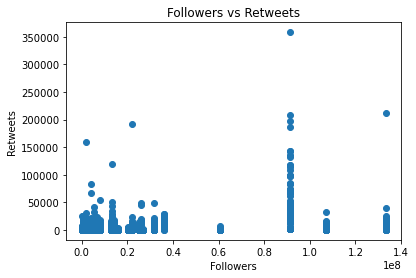

In [5]:
### Interpreting our data:
# Correlation Matrix
display(df.corr())

# scatter plot to show how followers relate to retweets
plt.scatter(df['followers'], df['retweets'])
plt.xlabel('Followers')
plt.ylabel('Retweets')
plt.title('Followers vs Retweets')
plt.show()

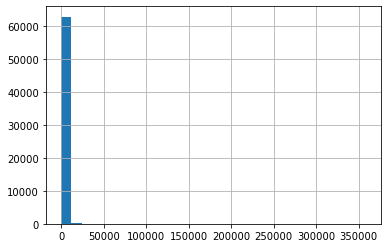

In [199]:
df['retweets'].hist(bins=30);

We can see that followers and lists seem to have a high correlation with retweets, but much of this is driven by outliers as we'll see after filtering down our data. What about our target?

Text(0, 0.5, 'Tweets')

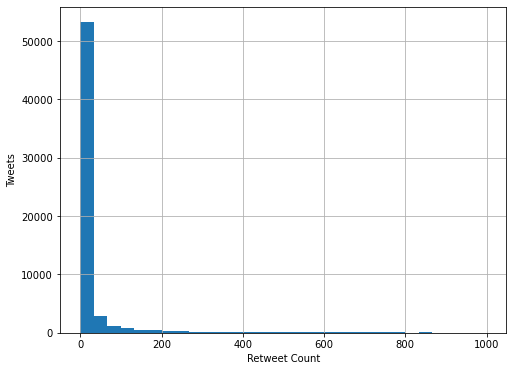

In [378]:
# Histogram of target (clamped to under 1000 retweets)
plt.figure(figsize=(8, 6))
df['retweets'].loc[df['retweets'] < 1000].hist(bins=30)
plt.xlabel('Retweet Count')
plt.ylabel('Tweets')

Here we can see that our prediction target is quite rare. This will make prediction difficult.

# Natural Language Processing
To get the most out of our text data, we'll try a multiscale analysis, each layer getting a bit more abstract. First we'll look at words themselves with a traditional Bag Of Words method, then document embeddings using ROBERTA-large, then topics from Top2Vec. Then we analyze and select our features at each layer of NLP abstraction and integrate with metadata into a final predictive model.

### Bag of Words
The simplest part of our NLP, we will just identify word (or word pairing(bigram)) frequency.

In [202]:
# We'll filter down our words to some range of semi-frequent words
max_doc_frequency = 0.04
min_doc_frequency = 0.004

vectorizer = CountVectorizer(lowercase=True, stop_words={'english'}, ngram_range=(1, 2), max_df=max_doc_frequency, min_df=min_doc_frequency)
docs = df.tweet.tolist()
words = vectorizer.fit_transform(docs)
BOW = pd.DataFrame(words.toarray(), columns=vectorizer.get_feature_names())
BOW = BOW.add_suffix('_BOW')

In [203]:
display(BOW.shape)
BOW.sample(3)

(63033, 940)

,000_BOW,10_BOW,100_BOW,100daysofcode_BOW,11_BOW,12_BOW,15_BOW,19_BOW,20_BOW,2020_BOW,...,you know_BOW,you ll_BOW,you need_BOW,you re_BOW,you to_BOW,you want_BOW,young_BOW,yourself_BOW,youtube_BOW,zero_BOW
58656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
32366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Document Embeddings
Check out the other notebook for the document embedding pipeline! We'll just be loading the data here.

In [8]:
### Loading our embeddings
emb = pd.read_csv('data/combined_document_embeddings.csv', index_col=0)
emb = emb.add_suffix('_EMB')

In [9]:
display(emb.shape)
emb.sample(3)

(63033, 1024)

,0_EMB,1_EMB,2_EMB,3_EMB,4_EMB,5_EMB,6_EMB,7_EMB,8_EMB,9_EMB,...,1014_EMB,1015_EMB,1016_EMB,1017_EMB,1018_EMB,1019_EMB,1020_EMB,1021_EMB,1022_EMB,1023_EMB
28447,0.002480,0.003906,-0.053020,0.028397,-0.029465,0.003238,-0.030310,-0.003719,-0.029621,0.045498,...,-0.040267,0.021600,0.017410,0.047956,-0.081254,0.011595,-0.019569,-0.031103,-0.018101,-0.057522
60518,-0.019508,-0.019187,-0.042247,-0.009392,-0.031852,-0.031059,0.019482,0.020751,0.029940,0.036340,...,-0.056557,0.027520,-0.023196,-0.006954,0.000672,0.044679,0.013246,0.054768,-0.029199,-0.020942
59993,0.037181,-0.039767,-0.014176,-0.025829,-0.004208,-0.058340,-0.012468,0.033414,0.003127,-0.052292,...,-0.012716,-0.014744,0.019038,0.088900,-0.017493,0.005958,0.007930,0.011664,0.000980,-0.022393


### Top2Vec
Same thing here, check out the notebook "Top2Vec_Data_Processing" for the pipeline.

In [513]:
# Import topics
top = pd.read_csv('data/topics.csv', index_col=0)
top = pd.get_dummies(top['topic'], drop_first=True).add_suffix('_TOP') # getting dummy columns

In [514]:
df.join(pd.read_csv('data/topics.csv', index_col=0))

,creation_time,user,tweet,retweets,favorites,followers,lists,topic
0,2022-09-26 20:14:17+00:00,GregL_Intel,I am looking forward to Intel Fellow @brendang...,10,54,4123,41,52
1,2022-09-26 20:11:39+00:00,GregL_Intel,Open software ecosystems are key to fostering ...,4,26,4123,41,242
2,2022-09-21 18:48:59+00:00,GregL_Intel,“AI Everywhere” will require optimized hardwar...,11,25,4123,41,306
3,2022-09-20 18:00:01+00:00,GregL_Intel,Our collaboration with @TU_Muenchen and the It...,2,12,4123,41,329
4,2022-09-19 22:52:59+00:00,GregL_Intel,"I am looking forward to having @AndrewYNg, fou...",19,85,4123,41,276
...,...,...,...,...,...,...,...,...
63028,2020-04-15 16:15:57+00:00,BarryJOGorman,@S_dF speaking of 'daily digital habits' - int...,2,1,909,103,76
63029,2020-04-15 13:54:53+00:00,BarryJOGorman,@nyike - if 'pushing envelope' - will always m...,1,0,909,103,189
63030,2021-02-03 18:17:58+00:00,RahulRJB,Even the mighty fall\n#FarmersProstest,1,2,47,0,232
63031,2022-10-06 06:42:42+00:00,jonsadventures,I've been writing notes for my second year non...,10,62,99,4,19


In [515]:
display(top.shape)
top.sample(3)

(63033, 447)

,1_TOP,2_TOP,3_TOP,4_TOP,5_TOP,6_TOP,7_TOP,8_TOP,9_TOP,10_TOP,...,438_TOP,439_TOP,440_TOP,441_TOP,442_TOP,443_TOP,444_TOP,445_TOP,446_TOP,447_TOP
6989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our data should be all ready now! We have four different datasets, 'df' contains our metadata and target, 'BOW' contains our bag-of-word data, 'emb' contains our document embeddings from ROBERTA, and 'top' contains our topic vectorization.

---
### Combining all data and filtering outliers

In [516]:
# Joining BOW data
total_df = df.drop(['creation_time', 'user', 'tweet', 'favorites'], axis=1).join(BOW)
display(total_df.shape)

# joining document embeddings
total_df = total_df.join(emb)
display(total_df.shape)

# joining topics
total_df = total_df.join(top)
display(total_df.shape)

# Data Preparation - filtering outliers for high/low follower count, and extremely high retweet count
total_df = total_df.loc[total_df['followers'] <= 50000].dropna(axis=1)
total_df = total_df.loc[total_df['followers'] >= 1000]
total_df = total_df[total_df['retweets'] <= 1000]
# total_df['retweets'] = np.log1p(total_df['retweets']) # Log Transform of y (target)

display(total_df.shape)

(63033, 943)

(63033, 1967)

(63033, 2414)

(28914, 2414)

### Splitting Data

In [573]:
# Assigning X and y values
X = total_df.drop(['retweets'], axis=1) #
y = total_df['retweets']

In [574]:
# Log transform of y
y_log = np.log1p(y)

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state=42) # can switch y to y_log

# Creating Validation Set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

### Feature Selection based on Correlation with y_train
Selecting based on correlation is fast and fairly accurate. In practice using sequentialfeatureselector didn't provide much better results

In [575]:
# Selecting the top and bottom 256 correlating features with target 'retweets'
# top_correlating_features = X_train.corrwith(y_train).sort_values(ascending=False).head(128)
# top_correlating_features = top_correlating_features.append(X_train.corrwith(y_train).sort_values(ascending=True).head(128))

In [576]:
# Selecting the top 256 correlating features with target 'retweets'
top_correlating_features = X_train.corrwith(y_train).sort_values(ascending=False).head(256)

In [577]:
# Filtering down to top 50
display(top_correlating_features.head(20)) # .filter(regex='_TOP')
top_50_correlating_features = top_correlating_features.head(50)
top_25_correlating_features = top_correlating_features.head(25)

followers            0.229123
100daysofcode_BOW    0.161215
113_TOP              0.152548
209_EMB              0.143945
916_EMB              0.133035
929_EMB              0.117520
482_EMB              0.116008
377_EMB              0.112633
276_EMB              0.108759
411_EMB              0.108055
215_EMB              0.107328
387_EMB              0.104993
62_EMB               0.104460
314_EMB              0.103213
python_BOW           0.102622
721_EMB              0.101860
168_EMB              0.100636
419_EMB              0.100248
618_EMB              0.098163
648_EMB              0.096192
dtype: float64

In [578]:
# Filtering X_train, X_val, and X_test to just our 256 top correlating features
X_train = X_train.filter(pd.DataFrame(top_correlating_features).transpose().columns)
X_val = X_val.filter(pd.DataFrame(top_correlating_features).transpose().columns)
X_test = X_test.filter(pd.DataFrame(top_correlating_features).transpose().columns)

### Feature Selection using SequentialFeatureSelector
This looks at our 256 top correlating features and narrows it down further to 64 features. This is an optional block, in practice I found that it didn't necessarily create any better results.

In [579]:
# # Instantiating our feature selector
# sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=50, direction='forward', cv=2)

# # Selecting features based on their importance in X_train
# sfs_train_top = sfs.fit_transform(X_train, y_train)
# X_sfs_train_top = pd.DataFrame(sfs_train_top, columns=(sfs.get_feature_names_out()))

# sfs_val_top = sfs.transform(X_val)
# X_sfs_val_top = pd.DataFrame(sfs_val_top, columns=(sfs.get_feature_names_out()))

# sfs_test_top = sfs.transform(X_test)
# X_sfs_test_top = pd.DataFrame(sfs_test_top, columns=(sfs.get_feature_names_out()))

In [580]:
# # Linear Regression Baseline on all selected features
# linreg = LinearRegression().fit(X_sfs_train_top, y_train)
# pred = linreg.predict(X_sfs_val_top); linreg_rmse = np.sqrt(MSE(y_val, pred)); print("LR RMSE : % f" %(linreg_rmse))

In [581]:
# X_train = X_sfs_train_top
# X_val = X_sfs_val_top
# X_test = X_sfs_test_top

# Machine Learning
Our data should be prepped and ready for machine learning! First we'll we'll create some functions to evaluate our models: 

In [2]:
### Model Evaluation Functions

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['root_mean_squared_error']), label='Train')
  plt.plot(history.epoch, np.array(history.history['val_root_mean_squared_error']), label = 'Val')
  plt.legend()
  plt.ylim([0,max(history.history['val_root_mean_squared_error'])])

def plot_prediction(test_labels, test_predictions):
  f = plt.figure(figsize=(8, 4))

  f1 = f.add_subplot(1,2,1)
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())

  error = test_predictions - test_labels
  f2 = f.add_subplot(1,2,2)
  plt.hist(error, bins = 50)
  plt.xlabel("Prediction Error")
  plt.ylabel("Count")
    
  plt.tight_layout()
  plt.show()

In [582]:
y_train.describe()

count    16263.000000
mean         1.456356
std          0.958327
min          0.000000
25%          0.693147
50%          1.098612
75%          1.791759
max          6.895683
Name: retweets, dtype: float64

Here we can see some information about our training data - 75% have 5 or fewer retweets. This means our data is really imbalanced. What would our RMSE be if we predicted all tweets had 0 retweets?

In [583]:
simple_baseline = pd.DataFrame(y_train)
simple_baseline['nulls'] = 0
simple_rmse = np.sqrt(MSE(y_train, simple_baseline['nulls']))
print("ALL 0 RMSE : % f" %(simple_rmse))

ALL 0 RMSE :  1.743361


In [584]:
simple_baseline = pd.DataFrame(y_train)
simple_baseline['nulls'] = y_train.mean()
simple_rmse = np.sqrt(MSE(y_train, simple_baseline['nulls']))
print("MIN CONST RMSE : % f" %(simple_rmse))
print(np.sqrt(MSE((np.exp(y_train) - 1), np.exp(simple_baseline['nulls']) - 1)))

MIN CONST RMSE :  0.958297
32.70358190535486


1.45 log y (or about 9 retweets) is the value that minimizes our RMSE, at .95 log (or 32.28 tweets rmse) - we'll consider .95 our first baseline.

How do statistical and machine learning methods compare?

### Linear Regression Baseline

In [585]:
# Linear Regression
linreg = LinearRegression().fit(X_train, y_train)
pred = linreg.predict(X_val); linreg_rmse = np.sqrt(MSE(y_val, pred)); print("LR RMSE : % f" %(linreg_rmse))
predictions = pd.DataFrame(pred).rename({0:'linreg_baseline'}, axis=1) # recording prediction
print(np.sqrt(MSE((np.exp(y_val) - 1), np.exp(pred) - 1)))

LR RMSE :  0.857167
29.09726291823842


When we feed in our data to a linear regression algorithm, we can see that it does perform a bit better. What about XGBoost?

### XGBoost Baseline

In [586]:
start = datetime.datetime.now()

progress = dict(); eval_metric = ["rmse"]; eval_set = [(X_val, y_val)]
XGB = xgboost.XGBRegressor(early_stopping_rounds=10) # , early_stopping_rounds=1
XGBhist = XGB.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)

end = datetime.datetime.now(); elapsed = end-start; print('Training took a total of {}'.format(elapsed))
pred = XGB.predict(X_val); xgb_b_rmse = np.sqrt(MSE(y_val, pred)); print("LR RMSE : % f" %(xgb_b_rmse))

[0]	validation_0-rmse:1.14187
[1]	validation_0-rmse:1.01230


C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:0.94616
[3]	validation_0-rmse:0.90886
[4]	validation_0-rmse:0.88435
[5]	validation_0-rmse:0.87140
[6]	validation_0-rmse:0.86336
[7]	validation_0-rmse:0.86022
[8]	validation_0-rmse:0.85710
[9]	validation_0-rmse:0.85493
[10]	validation_0-rmse:0.85246
[11]	validation_0-rmse:0.85120
[12]	validation_0-rmse:0.85071
[13]	validation_0-rmse:0.84751
[14]	validation_0-rmse:0.84533
[15]	validation_0-rmse:0.84664
[16]	validation_0-rmse:0.84617
[17]	validation_0-rmse:0.84534
[18]	validation_0-rmse:0.84538
[19]	validation_0-rmse:0.84533
[20]	validation_0-rmse:0.84535
[21]	validation_0-rmse:0.84552
[22]	validation_0-rmse:0.84548
[23]	validation_0-rmse:0.84555
[24]	validation_0-rmse:0.84506
[25]	validation_0-rmse:0.84425
[26]	validation_0-rmse:0.84404
[27]	validation_0-rmse:0.84460
[28]	validation_0-rmse:0.84427
[29]	validation_0-rmse:0.84410
[30]	validation_0-rmse:0.84381
[31]	validation_0-rmse:0.84114
[32]	validation_0-rmse:0.84103
[33]	validation_0-rmse:0.84071
[34]	validation_

Here we can see our XGBoost baseline is a little better. With this much data, we are probably overfitting.

In [587]:
predictions = predictions.join(pd.DataFrame(pred)).rename({0:'XGB_baseline'}, axis=1) # recording prediction

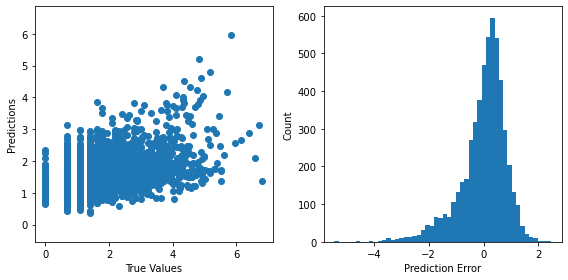

In [588]:
val_predictions = XGB.predict(X_val).flatten()
plot_prediction(y_val, val_predictions)

# Baselines for split Data
One thing we can try is an ensemble model, where we perform machine learning on each of our Natural Language Processing datasets (as well as metadata) separately and then combine them. Let's try a Linear Regression baseline for each dataset considered separately.

### Metadata Baseline

In [589]:
# Linear Regression
linreg = LinearRegression().fit(X_train[['followers', 'lists']], y_train)
meta_pred = linreg.predict(X_val[['followers', 'lists']]); linreg_rmse = np.sqrt(MSE(y_val, meta_pred)); print("LR RMSE : % f" %(linreg_rmse))
predictions = predictions.join(pd.DataFrame(meta_pred)).rename({0:'linreg_meta_baseline'}, axis=1) # recording prediction

LR RMSE :  0.921444


### Bag Of Words Baseline

In [590]:
# Linear Regression
linreg = LinearRegression().fit(X_train.filter(regex='_BOW'), y_train)
bow_pred = linreg.predict(X_val.filter(regex='_BOW')); linreg_rmse = np.sqrt(MSE(y_val, bow_pred)); print("LR RMSE : % f" %(linreg_rmse))
predictions = predictions.join(pd.DataFrame(bow_pred)).rename({0:'linreg_bow_baseline'}, axis=1) # recording prediction

LR RMSE :  0.930400


## Document Embeddings Baseline

In [591]:
# Linear Regression
linreg = LinearRegression().fit(X_train.filter(regex='_EMB'), y_train)
emb_pred = linreg.predict(X_val.filter(regex='_EMB')); linreg_rmse = np.sqrt(MSE(y_val, emb_pred)); print("LR RMSE : % f" %(linreg_rmse))
predictions = predictions.join(pd.DataFrame(emb_pred)).rename({0:'linreg_emb_baseline'}, axis=1) # recording prediction

LR RMSE :  0.909485


### Topic Vectorization Baseline

In [592]:
# Linear Regression
linreg = LinearRegression().fit(X_train.filter(regex='_TOP'), y_train)
top_pred = linreg.predict(X_val.filter(regex='_TOP')); linreg_rmse = np.sqrt(MSE(y_val, top_pred)); print("LR RMSE : % f" %(linreg_rmse))
predictions = predictions.join(pd.DataFrame(top_pred)).rename({0:'linreg_top_baseline'}, axis=1) # recording prediction

LR RMSE :  0.937803


We can see that none of these split models outperform our combined model baselines. What if we create an ensemble from our predictions?

### Ensemble Baseline

In [571]:
ensemble_pred = pd.DataFrame([meta_pred, bow_pred, emb_pred, top_pred]).transpose().mean(axis=1)
ensemble_rmse = np.sqrt(MSE(y_val, ensemble_pred)); print("LR RMSE : % f" %(ensemble_rmse))
predictions = predictions.join(pd.DataFrame(ensemble_pred)).rename({0:'linreg_ensemble_baseline'}, axis=1) # recording prediction

LR RMSE :  0.901458


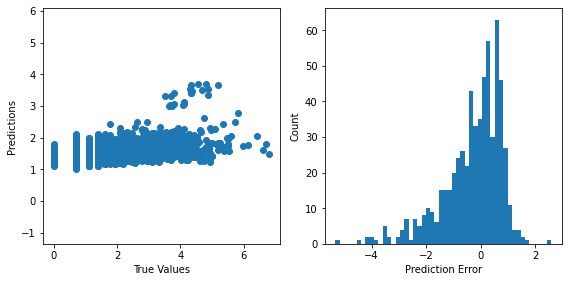

In [572]:
plot_prediction(y_val, ensemble)

This also What if we tried this with a potentially better performing machine learning algorithm?

## XGBoost Ensemble

### Metadata XGBoost

In [31]:
# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_val[['followers', 'lists']], y_val)]; val_metric = ["rmse"]
XGB_meta = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGB_meta_hist = XGB_meta.fit(X_train[['followers', 'lists']], y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed));
val_meta_pred = XGB_meta.predict(X_val[['followers', 'lists']]); rmse = np.sqrt(MSE(y_val, val_meta_pred)); print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:1.13898
[1]	validation_0-rmse:1.00745
[2]	validation_0-rmse:0.93439
[3]	validation_0-rmse:0.89358
[4]	validation_0-rmse:0.87024
[5]	validation_0-rmse:0.85662
[6]	validation_0-rmse:0.85047
[7]	validation_0-rmse:0.84495
[8]	validation_0-rmse:0.84172
[9]	validation_0-rmse:0.83931
[10]	validation_0-rmse:0.83435
[11]	validation_0-rmse:0.83366
[12]	validation_0-rmse:0.83288
[13]	validation_0-rmse:0.83272
[14]	validation_0-rmse:0.82988
[15]	validation_0-rmse:0.82859
[16]	validation_0-rmse:0.82809
[17]	validation_0-rmse:0.82665
[18]	validation_0-rmse:0.82632
[19]	validation_0-rmse:0.82537
[20]	validation_0-rmse:0.82496
[21]	validation_0-rmse:0.82477
[22]	validation_0-rmse:0.82422
[23]	validation_0-rmse:0.82426
[24]	validation_0-rmse:0.82376
[25]	validation_0-rmse:0.82307
[26]	validation_0-rmse:0.82290
[27]	validation_0-rmse:0.82232
[28]	validation_0-rmse:0.82163
[29]	validation_0-rmse:0.82105
[30]	validation_0-rmse:0.82070
[31]	validation_0-rmse:0.82064
[32]	validation_0-

C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-rmse:0.81624
[56]	validation_0-rmse:0.81615
[57]	validation_0-rmse:0.81617
[58]	validation_0-rmse:0.81612
[59]	validation_0-rmse:0.81609
[60]	validation_0-rmse:0.81602
[61]	validation_0-rmse:0.81572
[62]	validation_0-rmse:0.81564
[63]	validation_0-rmse:0.81560
[64]	validation_0-rmse:0.81563
[65]	validation_0-rmse:0.81558
[66]	validation_0-rmse:0.81542
[67]	validation_0-rmse:0.81544
[68]	validation_0-rmse:0.81536
[69]	validation_0-rmse:0.81535
[70]	validation_0-rmse:0.81541
[71]	validation_0-rmse:0.81546
[72]	validation_0-rmse:0.81543
[73]	validation_0-rmse:0.81545
[74]	validation_0-rmse:0.81544
[75]	validation_0-rmse:0.81547
[76]	validation_0-rmse:0.81542
[77]	validation_0-rmse:0.81544
[78]	validation_0-rmse:0.81545
[79]	validation_0-rmse:0.81543
[80]	validation_0-rmse:0.81542
[81]	validation_0-rmse:0.81544
[82]	validation_0-rmse:0.81543
[83]	validation_0-rmse:0.81542
[84]	validation_0-rmse:0.81546
[85]	validation_0-rmse:0.81543
[86]	validation_0-rmse:0.81544
[87]	val

In [230]:
predictions = predictions.join(pd.DataFrame(val_meta_pred)).rename({0:'XGB_metadata_baseline'}, axis=1) # recording prediction

### BOW XGBoost

In [32]:
# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_val.filter(regex='_BOW'), y_val)]; val_metric = ["rmse"]
XGB_bow = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGB_bow_hist = XGB_bow.fit(X_train.filter(regex='_BOW'), y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed)); print(progress)
val_bow_pred = XGB_bow.predict(X_val.filter(regex='_BOW')); rmse = np.sqrt(MSE(y_val, val_bow_pred)); print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:1.16328
[1]	validation_0-rmse:1.05276
[2]	validation_0-rmse:0.99357
[3]	validation_0-rmse:0.96309
[4]	validation_0-rmse:0.94665
[5]	validation_0-rmse:0.93819
[6]	validation_0-rmse:0.93390
[7]	validation_0-rmse:0.93190
[8]	validation_0-rmse:0.92975
[9]	validation_0-rmse:0.92860
[10]	validation_0-rmse:0.92766
[11]	validation_0-rmse:0.92752
[12]	validation_0-rmse:0.92689
[13]	validation_0-rmse:0.92671
[14]	validation_0-rmse:0.92658
[15]	validation_0-rmse:0.92658
[16]	validation_0-rmse:0.92632
[17]	validation_0-rmse:0.92666
[18]	validation_0-rmse:0.92678
[19]	validation_0-rmse:0.92671
[20]	validation_0-rmse:0.92681
[21]	validation_0-rmse:0.92666
[22]	validation_0-rmse:0.92703
[23]	validation_0-rmse:0.92707
[24]	validation_0-rmse:0.92734
[25]	validation_0-rmse:0.92772
[26]	validation_0-rmse:0.92792
[27]	validation_0-rmse:0.92818
[28]	validation_0-rmse:0.92836
[29]	validation_0-rmse:0.92840
[30]	validation_0-rmse:0.92865
[31]	validation_0-rmse:0.92902
[32]	validation_0-

C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.92956
[34]	validation_0-rmse:0.93000
[35]	validation_0-rmse:0.93022
Training took a total of 0:00:00.238001
{}
RMSE :  0.926319


In [231]:
predictions = predictions.join(pd.DataFrame(val_bow_pred)).rename({0:'XGB_bow_baseline'}, axis=1) # recording prediction

### Embeddings XGBoost

In [33]:
# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_val.filter(regex='_EMB'), y_val)]; val_metric = ["rmse"]
XGB_emb = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGB_emb_hist = XGB_emb.fit(X_train.filter(regex='_EMB'), y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed)); print(progress)
val_emb_pred = XGB_emb.predict(X_val.filter(regex='_EMB')); rmse = np.sqrt(MSE(y_val, val_emb_pred)); print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:1.16298


C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:1.05437
[2]	validation_0-rmse:0.99530
[3]	validation_0-rmse:0.96304
[4]	validation_0-rmse:0.94606
[5]	validation_0-rmse:0.93524
[6]	validation_0-rmse:0.93070
[7]	validation_0-rmse:0.92940
[8]	validation_0-rmse:0.92847
[9]	validation_0-rmse:0.92761
[10]	validation_0-rmse:0.92773
[11]	validation_0-rmse:0.92838
[12]	validation_0-rmse:0.92891
[13]	validation_0-rmse:0.92822
[14]	validation_0-rmse:0.92805
[15]	validation_0-rmse:0.92631
[16]	validation_0-rmse:0.92635
[17]	validation_0-rmse:0.92596
[18]	validation_0-rmse:0.92671
[19]	validation_0-rmse:0.92597
[20]	validation_0-rmse:0.92564
[21]	validation_0-rmse:0.92566
[22]	validation_0-rmse:0.92580
[23]	validation_0-rmse:0.92607
[24]	validation_0-rmse:0.92620
[25]	validation_0-rmse:0.92628
[26]	validation_0-rmse:0.92622
[27]	validation_0-rmse:0.92628
[28]	validation_0-rmse:0.92719
[29]	validation_0-rmse:0.92746
[30]	validation_0-rmse:0.92689
[31]	validation_0-rmse:0.92705
[32]	validation_0-rmse:0.92728
[33]	validation_0

In [232]:
predictions = predictions.join(pd.DataFrame(val_emb_pred)).rename({0:'XGB_emb_baseline'}, axis=1) # recording prediction

### Topic Vectorization XGBoost

In [34]:
# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_val.filter(regex='_TOP'), y_val)]; val_metric = ["rmse"]
XGB_top = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGB_top_hist = XGB_top.fit(X_train.filter(regex='_TOP'), y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed)); print(progress)
val_top_pred = XGB_top.predict(X_val.filter(regex='_TOP')); rmse = np.sqrt(MSE(y_val, val_top_pred)); print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:1.16369
[1]	validation_0-rmse:1.05520
[2]	validation_0-rmse:0.99717
[3]	validation_0-rmse:0.96780
[4]	validation_0-rmse:0.95232
[5]	validation_0-rmse:0.94496
[6]	validation_0-rmse:0.94126
[7]	validation_0-rmse:0.93923
[8]	validation_0-rmse:0.93846
[9]	validation_0-rmse:0.93802
[10]	validation_0-rmse:0.93775
[11]	validation_0-rmse:0.93773
[12]	validation_0-rmse:0.93771
[13]	validation_0-rmse:0.93766
[14]	validation_0-rmse:0.93770
[15]	validation_0-rmse:0.93772
[16]	validation_0-rmse:0.93771
[17]	validation_0-rmse:0.93774
[18]	validation_0-rmse:0.93775
[19]	validation_0-rmse:0.93775
[20]	validation_0-rmse:0.93777
[21]	validation_0-rmse:0.93778
[22]	validation_0-rmse:0.93778
[23]	validation_0-rmse:0.93779
[24]	validation_0-rmse:0.93779
[25]	validation_0-rmse:0.93779
[26]	validation_0-rmse:0.93779
[27]	validation_0-rmse:0.93780
[28]	validation_0-rmse:0.93780
[29]	validation_0-rmse:0.93780
[30]	validation_0-rmse:0.93780
[31]	validation_0-rmse:0.93780
[32]	validation_0-

C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [233]:
predictions = predictions.join(pd.DataFrame(val_top_pred)).rename({0:'XGB_top_baseline'}, axis=1) # recording prediction

### XGBoost Ensemble

In [35]:
ensemble = pd.DataFrame([val_meta_pred, val_bow_pred, val_emb_pred, val_top_pred]).transpose().mean(axis=1)
ensemble_rmse = np.sqrt(MSE(y_val, ensemble)); print("MEAN RMSE : % f" %(ensemble_rmse))

MEAN RMSE :  0.863011


In [234]:
predictions = predictions.join(pd.DataFrame(ensemble)).rename({0:'XGB_mean_ensemble'}, axis=1) # recording prediction

Here our results are more complicated. XGBoost on just metadata outperformed all of our other models, including our ensemble model. It looks like that's our new baseline, at RMSE just over 28. Can we use NLP to improve our predictions from metadata alone?

Maybe we can ensemble these models in a more sophisticated way, compared to just taking the mean of their predictions? The next thing we will try is training an XGBoost model on the predictions of the other models.

In [36]:
# Collect Training Set Predictions
train_meta_pred = XGB_meta.predict(X_train[['followers', 'lists']]);
train_bow_pred = XGB_bow.predict(X_train.filter(regex='_BOW'));
train_emb_pred = XGB_emb.predict(X_train.filter(regex='_EMB'));
train_top_pred = XGB_top.predict(X_train.filter(regex='_TOP'));

# Collect Validation Set Predictions
val_meta_pred = XGB_meta.predict(X_val[['followers', 'lists']]);
val_bow_pred = XGB_bow.predict(X_val.filter(regex='_BOW'));
val_emb_pred = XGB_emb.predict(X_val.filter(regex='_EMB'));
val_top_pred = XGB_top.predict(X_val.filter(regex='_TOP'));

# Aggregate Training and validation Set Predictions
X_train_XGB_preds = pd.DataFrame([train_meta_pred, train_bow_pred, train_emb_pred, train_top_pred]).transpose()
X_val_XGB_preds = pd.DataFrame([val_meta_pred, val_bow_pred, val_emb_pred, val_top_pred]).transpose()

# Linear Regression Ensemble Prediction
linreg = LinearRegression().fit(X_train_XGB_preds, y_train)
linreg_ensemble_pred = linreg.predict(X_val_XGB_preds); linreg_e_rmse = np.sqrt(MSE(y_val, linreg_ensemble_pred)); print("LR RMSE : % f" %(linreg_e_rmse))

# XGBoost model, training on training predictions and y, then validating with val predictions from previous models
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_val_XGB_preds, y_val)]; val_metric = ["rmse"]
XGB_ensemble = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=10)
XGBhist_ensemble = XGB_ensemble.fit(X_train_XGB_preds, y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed))
ens_val_pred = XGB_ensemble.predict(X_val_XGB_preds); rmse = np.sqrt(MSE(y_val, ens_val_pred)); print("XGB RMSE : % f" %(rmse))

LR RMSE :  0.861102
[0]	validation_0-rmse:1.12753
[1]	validation_0-rmse:0.99740
[2]	validation_0-rmse:0.92852
[3]	validation_0-rmse:0.89383
[4]	validation_0-rmse:0.87681
[5]	validation_0-rmse:0.86974
[6]	validation_0-rmse:0.86716
[7]	validation_0-rmse:0.86603
[8]	validation_0-rmse:0.86662
[9]	validation_0-rmse:0.86673
[10]	validation_0-rmse:0.86651
[11]	validation_0-rmse:0.86711
[12]	validation_0-rmse:0.86743
[13]	validation_0-rmse:0.86794
[14]	validation_0-rmse:0.86846
[15]	validation_0-rmse:0.86826
[16]	validation_0-rmse:0.86823
Training took a total of 0:00:00.123003
XGB RMSE :  0.866027


C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [236]:
predictions = predictions.join(pd.DataFrame(ens_val_pred)).rename({0:'XGB_XGB_ensemble'}, axis=1) # recording prediction

What about a linear regression model trained on model predictions?

In [238]:
# What about Linear Regression?
linreg_ens = LinearRegression().fit(X_train_XGB_preds, y_train)
linreg_ens_pred = linreg_ens.predict(X_val_XGB_preds); linreg_e_rmse = np.sqrt(MSE(y_val, linreg_ens_pred)); print("LR RMSE : % f" %(linreg_e_rmse))

LR RMSE :  0.860438


In [239]:
predictions = predictions.join(pd.DataFrame(linreg_ens_pred)).rename({0:'XGB_linreg_ensemble'}, axis=1) # recording prediction

It seems that training machine learning models on our ensemble of predictions performed only slightly better than just taking the mean of our predictions - and taking the mean of our predictions performed worse than just predicting retweets from tweet metadata using XGBoost! Let's look at how these model predictions correlate with our target:

In [253]:
# Checking prediction correlations with target
predictions.join(pd.DataFrame(y_val).reset_index(drop=True)).corr()['retweets'].sort_values(ascending=False)

retweets                    1.000000
XGB_metadata_baseline       0.526989
XGB_mean_ensemble           0.523405
XGB_baseline                0.482187
XGB_linreg_ensemble         0.462157
XGB_XGB_ensemble            0.459106
linreg_baseline             0.451855
linreg_ensemble_baseline    0.438294
linreg_emb_baseline         0.319574
XGB_emb_baseline            0.278243
linreg_meta_baseline        0.278147
XGB_bow_baseline            0.259668
linreg_bow_baseline         0.250575
XGB_top_baseline            0.211187
linreg_top_baseline         0.210804
Name: retweets, dtype: float64

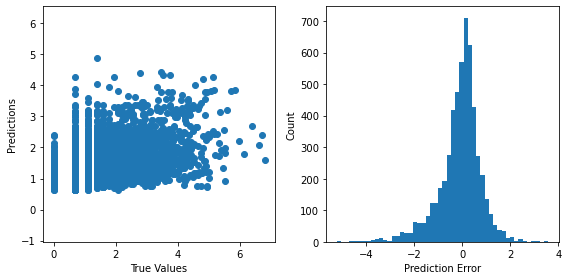

In [254]:
plot_prediction(y_val, ens_val_pred) # val_meta_pred, val_emb_pred, val_emb_pred, val_top_pred

It looks like XGBoost on metadata is still the most informative predictor, followed by our mean ensemble on split XGB models.

## TabNet
TabNet is a deep learning system developed by google that can reportedy beat XGBoost on Tabular Data. It's also reportedly capable of doing the bulk of our feature engineering for us. What happens if we just feed our Data into TabNet?

In [255]:
# Converting data to Numpy Arrays
X_train_array = X_train.values
y_train_array = y_train.values.reshape(-1, 1)
X_val_array = X_val.values
y_val_array = y_val.values.reshape(-1, 1)

In [128]:
TabNet = TabNetRegressor()
max_epochs = 100

TN_hist = TabNet.fit(
    X_train=X_train_array, y_train=y_train_array,
    eval_set=[(X_train_array, y_train_array), (X_val_array, y_val_array)],
    eval_name=['train', 'val'],
    eval_metric=['mae', 'rmse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
) 

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.67484 | train_mae: 0.68711 | train_rmse: 1.00718 | val_mae: 0.68698 | val_rmse: 1.00872 |  0:00:03s
epoch 1  | loss: 0.96616 | train_mae: 0.70479 | train_rmse: 0.9596  | val_mae: 0.70579 | val_rmse: 0.96071 |  0:00:06s
epoch 2  | loss: 0.91284 | train_mae: 0.69819 | train_rmse: 0.96533 | val_mae: 0.69888 | val_rmse: 0.96651 |  0:00:10s
epoch 3  | loss: 0.89995 | train_mae: 0.70347 | train_rmse: 0.95828 | val_mae: 0.70437 | val_rmse: 0.95918 |  0:00:13s
epoch 4  | loss: 0.88954 | train_mae: 0.70843 | train_rmse: 0.95728 | val_mae: 0.70928 | val_rmse: 0.95798 |  0:00:17s
epoch 5  | loss: 0.87931 | train_mae: 0.69986 | train_rmse: 0.9613  | val_mae: 0.70033 | val_rmse: 0.96206 |  0:00:20s
epoch 6  | loss: 0.88695 | train_mae: 0.6928  | train_rmse: 0.95058 | val_mae: 0.69307 | val_rmse: 0.95112 |  0:00:23s
epoch 7  | loss: 0.867   | train_mae: 0.71322 | train_rmse: 0.93474 | val_mae: 0.7127  | val_rmse: 0.93257 |  0:00:27s
epoch 8  | loss: 0.85421 | train_mae: 0.69505 | 

epoch 69 | loss: 0.5545  | train_mae: 0.53136 | train_rmse: 0.72359 | val_mae: 0.64373 | val_rmse: 0.89436 |  0:04:05s
epoch 70 | loss: 0.56263 | train_mae: 0.55055 | train_rmse: 0.72563 | val_mae: 0.68081 | val_rmse: 0.91987 |  0:04:09s
epoch 71 | loss: 0.55273 | train_mae: 0.52993 | train_rmse: 0.71724 | val_mae: 0.64459 | val_rmse: 0.89436 |  0:04:12s
epoch 72 | loss: 0.54089 | train_mae: 0.52539 | train_rmse: 0.70904 | val_mae: 0.65462 | val_rmse: 0.90801 |  0:04:16s
epoch 73 | loss: 0.52908 | train_mae: 0.52327 | train_rmse: 0.70153 | val_mae: 0.65609 | val_rmse: 0.90293 |  0:04:19s
epoch 74 | loss: 0.5246  | train_mae: 0.51724 | train_rmse: 0.69935 | val_mae: 0.65741 | val_rmse: 0.91107 |  0:04:23s
epoch 75 | loss: 0.52848 | train_mae: 0.51639 | train_rmse: 0.69394 | val_mae: 0.65296 | val_rmse: 0.90032 |  0:04:26s
epoch 76 | loss: 0.51967 | train_mae: 0.50988 | train_rmse: 0.69434 | val_mae: 0.64675 | val_rmse: 0.90489 |  0:04:29s
epoch 77 | loss: 0.51721 | train_mae: 0.51148 | 

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [129]:
tn_0_preds = TabNet.predict(X_val_array)
val_score = MSE(y_pred=tn_0_preds, y_true=y_val_array)

print(f"FINAL TEST RMSE FOR DATA : {np.sqrt(val_score)}")

FINAL TEST RMSE FOR DATA : 0.8775939506358597


In [256]:
predictions = predictions.join(pd.DataFrame(tn_0_preds)).rename({0:'Tabnet_baseline'}, axis=1) # recording prediction

It looks like TabNet on all our NLP and metadata performed just a little worse than just XGBoost on metadata alone. What if we try TabNet on our NLP datasets separately and combine them?

### TabNet on Metadata

In [43]:
# Converting filtered data to Numpy Arrays
X_train_array = X_train[['followers', 'lists']].values
y_train_array = y_train.values.reshape(-1, 1)
X_val_array = X_val[['followers', 'lists']].values
y_val_array = y_val.values.reshape(-1, 1)

In [44]:
TabNet_1 = TabNetRegressor()
max_epochs = 25

TN_hist_1 = TabNet_1.fit(
    X_train=X_train_array, y_train=y_train_array,
    eval_set=[(X_train_array, y_train_array), (X_val_array, y_val_array)],
    eval_name=['train', 'val'],
    eval_metric=['mae', 'rmse'],
    max_epochs=max_epochs,
    patience=25,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
) 

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54511 | train_mae: 1.60572 | train_rmse: 2.00615 | val_mae: 1.602   | val_rmse: 2.00506 |  0:00:01s
epoch 1  | loss: 0.85498 | train_mae: 1.0571  | train_rmse: 1.34445 | val_mae: 1.05067 | val_rmse: 1.34254 |  0:00:02s
epoch 2  | loss: 0.8444  | train_mae: 0.95321 | train_rmse: 1.2202  | val_mae: 0.95052 | val_rmse: 1.22064 |  0:00:02s
epoch 3  | loss: 0.84567 | train_mae: 0.7464  | train_rmse: 0.95044 | val_mae: 0.74542 | val_rmse: 0.95    |  0:00:03s
epoch 4  | loss: 0.84072 | train_mae: 0.71441 | train_rmse: 0.9346  | val_mae: 0.71042 | val_rmse: 0.93292 |  0:00:05s
epoch 5  | loss: 0.83818 | train_mae: 0.70787 | train_rmse: 0.93949 | val_mae: 0.70441 | val_rmse: 0.94019 |  0:00:06s
epoch 6  | loss: 0.84087 | train_mae: 0.71023 | train_rmse: 0.93905 | val_mae: 0.71001 | val_rmse: 0.93997 |  0:00:07s
epoch 7  | loss: 0.83365 | train_mae: 0.73707 | train_rmse: 0.94805 | val_mae: 0.73568 | val_rmse: 0.9483  |  0:00:08s
epoch 8  | loss: 0.83622 | train_mae: 0.72169 | 

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [45]:
tn1_preds = TabNet_1.predict(X_val_array)
val_score_1 = MSE(y_pred=tn1_preds, y_true=y_val_array)

print(f"FINAL VAL RMSE FOR DATA : {np.sqrt(val_score_1)}")

FINAL VAL RMSE FOR DATA : 0.8949739285340979


In [257]:
predictions = predictions.join(pd.DataFrame(tn1_preds)).rename({0:'Tabnet_metadata'}, axis=1) # recording prediction

### TabNet on BOW Data

In [46]:
# Converting filtered data to Numpy Arrays
X_train_array = X_train.filter(regex='_BOW').values
y_train_array = y_train.values.reshape(-1, 1)
X_val_array = X_val.filter(regex='_BOW').values
y_val_array = y_val.values.reshape(-1, 1)

In [47]:
TabNet_2 = TabNetRegressor()
max_epochs = 25

TN_hist_2 = TabNet_2.fit(
    X_train=X_train_array, y_train=y_train_array,
    eval_set=[(X_train_array, y_train_array), (X_val_array, y_val_array)],
    eval_name=['train', 'test'],
    eval_metric=['mae', 'rmse'],
    max_epochs=max_epochs,
    patience=25,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
) 

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.14049 | train_mae: 0.69582 | train_rmse: 0.98044 | test_mae: 0.6965  | test_rmse: 0.98173 |  0:00:01s
epoch 1  | loss: 1.07111 | train_mae: 0.71585 | train_rmse: 0.95984 | test_mae: 0.71726 | test_rmse: 0.96044 |  0:00:02s
epoch 2  | loss: 0.93686 | train_mae: 0.71069 | train_rmse: 0.95574 | test_mae: 0.71266 | test_rmse: 0.95737 |  0:00:03s
epoch 3  | loss: 0.90611 | train_mae: 0.69532 | train_rmse: 0.96382 | test_mae: 0.69734 | test_rmse: 0.96649 |  0:00:04s
epoch 4  | loss: 0.90641 | train_mae: 0.70583 | train_rmse: 0.95261 | test_mae: 0.70841 | test_rmse: 0.9553  |  0:00:05s
epoch 5  | loss: 0.89785 | train_mae: 0.70482 | train_rmse: 0.9504  | test_mae: 0.70746 | test_rmse: 0.95411 |  0:00:06s
epoch 6  | loss: 0.90414 | train_mae: 0.71372 | train_rmse: 0.94526 | test_mae: 0.7188  | test_rmse: 0.95107 |  0:00:08s
epoch 7  | loss: 0.90733 | train_mae: 0.70637 | train_rmse: 0.95232 | test_mae: 0.70883 | test_rmse: 0.95571 |  0:00:09s
epoch 8  | loss: 0.88966 | train

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [48]:
tn2_preds = TabNet_2.predict(X_val_array)
val_score_2 = MSE(y_pred=tn2_preds, y_true=y_val)

print(f"FINAL TEST RMSE FOR DATA : {np.sqrt(val_score_2)}")

FINAL TEST RMSE FOR DATA : 0.9474791782490241


In [258]:
predictions = predictions.join(pd.DataFrame(tn2_preds)).rename({0:'Tabnet_bow'}, axis=1) # recording prediction

### TabNet on Document Embedding Data

In [49]:
# Converting filtered data to Numpy Arrays
X_train_array = X_train.filter(regex='_EMB').values
y_train_array = y_train.values.reshape(-1, 1)
X_val_array = X_val.filter(regex='_EMB').values
y_val_array = y_val.values.reshape(-1, 1)

In [50]:
TabNet_3 = TabNetRegressor()
max_epochs = 25

TN_hist_3 = TabNet_3.fit(
    X_train=X_train_array, y_train=y_train_array,
    eval_set=[(X_train_array, y_train_array), (X_val_array, y_val_array)],
    eval_name=['train', 'test'],
    eval_metric=['mae', 'rmse'],
    max_epochs=max_epochs,
    patience=25,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
) 

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.78425 | train_mae: 0.73051 | train_rmse: 1.09722 | test_mae: 0.7318  | test_rmse: 1.09941 |  0:00:02s
epoch 1  | loss: 1.05129 | train_mae: 0.70053 | train_rmse: 0.96487 | test_mae: 0.70128 | test_rmse: 0.96605 |  0:00:05s
epoch 2  | loss: 0.92391 | train_mae: 0.7183  | train_rmse: 0.95839 | test_mae: 0.71977 | test_rmse: 0.95939 |  0:00:07s
epoch 3  | loss: 0.9065  | train_mae: 0.73166 | train_rmse: 0.95826 | test_mae: 0.73366 | test_rmse: 0.95917 |  0:00:10s
epoch 4  | loss: 0.8994  | train_mae: 0.71109 | train_rmse: 0.95846 | test_mae: 0.71228 | test_rmse: 0.95944 |  0:00:12s
epoch 5  | loss: 0.89726 | train_mae: 0.71176 | train_rmse: 0.95812 | test_mae: 0.713   | test_rmse: 0.95909 |  0:00:15s
epoch 6  | loss: 0.88673 | train_mae: 0.70406 | train_rmse: 0.95934 | test_mae: 0.70493 | test_rmse: 0.9604  |  0:00:17s
epoch 7  | loss: 0.88354 | train_mae: 0.734   | train_rmse: 0.95855 | test_mae: 0.73597 | test_rmse: 0.95923 |  0:00:20s
epoch 8  | loss: 0.87632 | train

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [51]:
tn3_preds = TabNet_3.predict(X_val_array)
val_score_3 = MSE(y_pred=tn3_preds, y_true=y_val)

print(f"FINAL TEST RMSE FOR DATA : {np.sqrt(val_score_3)}")

FINAL TEST RMSE FOR DATA : 0.946094964329127


In [259]:
predictions = predictions.join(pd.DataFrame(tn3_preds)).rename({0:'Tabnet_emb'}, axis=1) # recording prediction

### TabNet on Top2Vec Data

In [52]:
# Converting filtered data to Numpy Arrays
X_train_array = X_train.filter(regex='_TOP').values # breaks?
y_train_array = y_train.values.reshape(-1, 1)

X_val_array = X_val.filter(regex='_TOP').values # breaks?
y_val_array = y_val.values.reshape(-1, 1)

In [53]:
TabNet_4 = TabNetRegressor()
max_epochs = 50

TN_hist_4 = TabNet_4.fit(
    X_train=X_train_array, y_train=y_train_array,
    eval_set=[(X_train_array, y_train_array), 
              (X_val_array, y_val_array)],
    eval_name=['train', 'val'],
    eval_metric=['mae', 'rmse'],
    max_epochs=max_epochs,
    patience=25,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
) 

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.85878 | train_mae: 0.69017 | train_rmse: 0.99607 | val_mae: 0.69032 | val_rmse: 0.99807 |  0:00:01s
epoch 1  | loss: 1.02936 | train_mae: 0.76919 | train_rmse: 0.97397 | val_mae: 0.77202 | val_rmse: 0.97376 |  0:00:03s
epoch 2  | loss: 0.95003 | train_mae: 0.689   | train_rmse: 0.99265 | val_mae: 0.68969 | val_rmse: 0.99533 |  0:00:04s
epoch 3  | loss: 0.94791 | train_mae: 0.72835 | train_rmse: 0.95696 | val_mae: 0.72991 | val_rmse: 0.95784 |  0:00:06s
epoch 4  | loss: 0.92147 | train_mae: 0.69658 | train_rmse: 0.94557 | val_mae: 0.69853 | val_rmse: 0.94788 |  0:00:08s
epoch 5  | loss: 0.90313 | train_mae: 0.69435 | train_rmse: 0.95328 | val_mae: 0.69541 | val_rmse: 0.95509 |  0:00:09s
epoch 6  | loss: 0.90509 | train_mae: 0.75205 | train_rmse: 0.95222 | val_mae: 0.75419 | val_rmse: 0.9517  |  0:00:11s
epoch 7  | loss: 0.9039  | train_mae: 0.71789 | train_rmse: 0.94254 | val_mae: 0.72216 | val_rmse: 0.94726 |  0:00:12s
epoch 8  | loss: 0.89535 | train_mae: 0.69642 | 

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [54]:
tn4_preds = TabNet_4.predict(X_val_array)
val_score_4 = MSE(y_pred=tn4_preds, y_true=y_val)

print(f"FINAL TEST RMSE FOR DATA : {np.sqrt(val_score_4)}")

FINAL TEST RMSE FOR DATA : 0.9417111161687647


In [261]:
predictions = predictions.join(pd.DataFrame(tn4_preds)).rename({0:'Tabnet_top'}, axis=1) # recording prediction

### TabNet Ensemble

In [263]:
# Make training predictions with each TabNet model
tn1_train_preds = pd.DataFrame(TabNet_1.predict(X_train[['followers', 'lists']].values)[:])
tn2_train_preds = pd.DataFrame(TabNet_2.predict(X_train.filter(regex='_BOW').values)[:])
tn3_train_preds = pd.DataFrame(TabNet_3.predict(X_train.filter(regex='_EMB').values)[:])
tn4_train_preds = pd.DataFrame(TabNet_4.predict(X_train.filter(regex='_TOP').values)[:])

# Make validation predictions with each TabNet model
tn1_val_preds = pd.DataFrame(TabNet_1.predict(X_val[['followers', 'lists']].values)[:])
tn2_val_preds = pd.DataFrame(TabNet_2.predict(X_val.filter(regex='_BOW').values)[:])
tn3_val_preds = pd.DataFrame(TabNet_3.predict(X_val.filter(regex='_EMB').values)[:])
tn4_val_preds = pd.DataFrame(TabNet_4.predict(X_val.filter(regex='_TOP').values)[:])

# Aggregate Training Set Predictions
X_train_tn_preds = pd.DataFrame(data={'meta':list(tn1_train_preds[0]), 
                                      'bow':list(tn2_train_preds[0]), 
                                      'emb':list(tn3_train_preds[0]), 
                                      'top':list(tn4_train_preds[0])})
# and validation Set Predictions
X_val_tn_preds = pd.DataFrame(data={'meta':list(tn1_val_preds[0]), 
                                    'bow':list(tn2_val_preds[0]), 
                                    'emb':list(tn3_val_preds[0]), 
                                    'top':list(tn4_val_preds[0])})

# Take the mean of our model predictions and compare it to true values of our target
tn_mean_preds = X_val_tn_preds.mean(axis=1)
tn_val_ensemble_rmse = np.sqrt(MSE(y_val, tn_mean_preds)); print("RMSE : % f" %(tn_val_ensemble_rmse))

RMSE :  0.915648


In [265]:
predictions = predictions.join(pd.DataFrame(tn_mean_preds)).rename({0:'Tabnet_mean_ensemble'}, axis=1) # recording prediction

In [266]:
# Checking correlation of validation predictions with target 'retweets'
X_val_tn_preds.join(pd.DataFrame(y_val).reset_index(drop=True)).rename(columns={0:'Metadata', 1:'BOW', 2:'Embeddings', 3:'Top2Vec'}).corr()['retweets']

meta        0.364731
bow         0.161256
emb         0.236027
top         0.204705
retweets    1.000000
Name: retweets, dtype: float64

Well, we really did a deep dive on TabNet and ensembling methods, and our top baseline is still just looking at metadata and predicting that accounts with lots of followers will get more retweets. Looking at our NLP data separately from metadata, we can see that they do indeed have some predictive power, but considering nlp with metadata has so far not improved our predictive power.

In theory this predictive power between metadata and NLP could be combined, because our metadata and NLP pipelines are forming their predictions based on very different measures and sets of data, but experientially we haven't seen that yet.

Let's see if we can tune our XGB Hyperparameters to beat our current baseline.

# XGBoost Hyperparameter Tuning
### Bag Of Words tuning

In [57]:
# Parameters
optimize = 'neg_root_mean_squared_error'
XGB = xgboost.XGBRegressor(objective='reg:squarederror')

# Our hyperparameter grid, with some other options as comments - we'll use this grid for each of our XGB models and datasets
XGB_params = {
    'learning_rate' : [.02, .03, .05],
    'min_child_weight' : [5],
    'gamma' : [0.27, 0.3, 0.33],
#     'alpha' : [0.01], # L1 regularization
#     'eta': [1, 0.5],
    'eval_metric':['mlogloss'],
    'lambda':[1], # L2 regularization
    'booster' : ['gbtree'],
    'max_depth': [5, None],
    'n_estimators': [100, 120, 140],
    'colsample_bytree' : [0.5]
#     'subsample': [0.5]
}

In [58]:
start = datetime.datetime.now() # timing

# Searching Parameters
XGB3 = GridSearchCV(XGB, XGB_params, scoring=optimize, refit=optimize, cv=2, n_jobs=1, verbose=True)
XGB3.fit(X_train.filter(regex='_BOW'), y_train)

# Reporting best parameters
XGB_best_parameters = XGB3.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(XGB_best_parameters.keys()):
    print('%s: %r' % (param_name, XGB_best_parameters[param_name]))

end = datetime.datetime.now(); elapsed = end-start; print('Training took a total of {}'.format(elapsed)) # timing

# Validation RMSE report
xgb_pred_bow = XGB3.predict(X_val.filter(regex='_BOW'))
xgb_rmse = np.sqrt(MSE(y_val, xgb_pred_bow))
print("XGB RMSE : % f" %(xgb_rmse))

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Grid Search found the following optimal parameters: 
booster: 'gbtree'
colsample_bytree: 0.5
eval_metric: 'mlogloss'
gamma: 0.33
lambda: 1
learning_rate: 0.05
max_depth: None
min_child_weight: 5
n_estimators: 140
Training took a total of 0:00:18.706998
XGB RMSE :  0.924847


In [267]:
predictions = predictions.join(pd.DataFrame(xgb_pred_bow)).rename({0:'XGB_tuned_bow'}, axis=1) # recording prediction

### XGB Document Embedding Hyperparameter Tuning

In [59]:
start = datetime.datetime.now() # timing

# Searching Parameters
XGB4 = GridSearchCV(XGB, XGB_params, scoring=optimize, refit=optimize, cv=2, n_jobs=1, verbose=True)
XGB4.fit(X_train.filter(regex='_EMB'), y_train)

best_parameters = XGB4.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, XGB_best_parameters[param_name]))
    
end = datetime.datetime.now(); elapsed = end-start; print('Training took a total of {}'.format(elapsed)) # timing

# Validation RMSE
xgb_pred_emb = XGB4.predict(X_val.filter(regex='_EMB'))
xgb_rmse = np.sqrt(MSE(y_val, xgb_pred_emb))
print("XGB RMSE : % f" %(xgb_rmse))

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Grid Search found the following optimal parameters: 
booster: 'gbtree'
colsample_bytree: 0.5
eval_metric: 'mlogloss'
gamma: 0.33
lambda: 1
learning_rate: 0.05
max_depth: None
min_child_weight: 5
n_estimators: 140
Training took a total of 0:04:30.695532
XGB RMSE :  0.903017


In [268]:
predictions = predictions.join(pd.DataFrame(xgb_pred_emb)).rename({0:'XGB_tuned_emb'}, axis=1) # recording prediction

### XGB Topic Hyperparameter Tuning

In [60]:
start = datetime.datetime.now() # timing

# Searching Parameters
XGB5 = GridSearchCV(XGB, XGB_params, scoring=optimize, refit=optimize, cv=2, n_jobs=1, verbose=True)
XGB5.fit(X_train.filter(regex='_TOP'), y_train)

best_parameters = XGB5.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, XGB_best_parameters[param_name]))
    
end = datetime.datetime.now(); elapsed = end-start; print('Training took a total of {}'.format(elapsed)) # timing

# Validation RMSE
xgb_pred_top = XGB5.predict(X_val.filter(regex='_TOP'))
xgb_rmse = np.sqrt(MSE(y_val, xgb_pred_top))
print("XGB RMSE : % f" %(xgb_rmse))

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Grid Search found the following optimal parameters: 
booster: 'gbtree'
colsample_bytree: 0.5
eval_metric: 'mlogloss'
gamma: 0.33
lambda: 1
learning_rate: 0.05
max_depth: None
min_child_weight: 5
n_estimators: 140
Training took a total of 0:00:09.701002
XGB RMSE :  0.937653


In [269]:
predictions = predictions.join(pd.DataFrame(xgb_pred_top)).rename({0:'XGB_tuned_top'}, axis=1) # recording prediction

### XGB Metadata Hyperparameter Tuning

In [288]:
# Parameters
optimize = 'neg_root_mean_squared_error'
XGB = xgboost.XGBRegressor(objective='reg:squarederror')

# Our hyperparameter grid, with some other options as comments - we'll use this grid for each of our XGB models and datasets
XGB_params = {
    'learning_rate' : [.05, 0.2, 0.3],
    'min_child_weight' : [1, 3, 5],
    'gamma' : [0, 0.15, 0.33],
#     'eta': [1, 0.5],
    'eval_metric':['mlogloss'],
#     'alpha' : [0.01], # L1 regularization
    'lambda':[1], # L2 regularization
    'booster' : ['gbtree'],
    'max_depth': [6, None],
    'n_estimators': [140],
    'colsample_bytree' : [0.5]
#     'subsample': [0.8, 1]
}

In [289]:
start = datetime.datetime.now() # timing

# Searching Parameters
XGB6 = GridSearchCV(XGB, XGB_params, scoring=optimize, refit=optimize, cv=2, n_jobs=1, verbose=True)
XGB6.fit(X_train[['followers', 'lists']], y_train)

best_parameters = XGB6.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, XGB_best_parameters[param_name]))
    
end = datetime.datetime.now(); elapsed = end-start; print('Training took a total of {}'.format(elapsed)) # timing

# Validation RMSE
xgb_pred_meta = XGB6.predict(X_val[['followers', 'lists']])
xgb_rmse = np.sqrt(MSE(y_val, xgb_pred_meta))
print("XGB RMSE : % f" %(xgb_rmse))

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Grid Search found the following optimal parameters: 
booster: 'gbtree'
colsample_bytree: 0.5
eval_metric: 'mlogloss'
gamma: 0.33
lambda: 1
learning_rate: 0.05
max_depth: None
min_child_weight: 5
n_estimators: 140
Training took a total of 0:00:17.509119
XGB RMSE :  0.815383


In [270]:
predictions = predictions.join(pd.DataFrame(xgb_pred_meta)).rename({0:'XGB_tuned_meta'}, axis=1) # recording prediction

Hmm, well tuning our hyperparameters with our metadata has improved our baseline.

### Tuned XGB Ensemble

In [74]:
XGB_hype_bow =XGB3.predict(X_train.filter(regex='_BOW'))
XGB_hype_emb =XGB4.predict(X_train.filter(regex='_EMB'))
XGB_hype_top =XGB5.predict(X_train.filter(regex='_TOP'))
XGB_hype_meta = XGB6.predict(X_train[['followers', 'lists']])

X_train_XGB_preds = pd.DataFrame([XGB_hype_meta, XGB_hype_bow, XGB_hype_emb, XGB_hype_top]).transpose()
X_val_XGB_preds = pd.DataFrame([xgb_pred_meta, xgb_pred_bow, xgb_pred_emb, xgb_pred_top]).transpose()

print('mean ensemble on training set: ' + str(np.sqrt(MSE(y_train, X_train_XGB_preds.mean(axis=1)))))
print('mean ensemble on validation set: ' + str(np.sqrt(MSE(y_val, X_val_XGB_preds.mean(axis=1)))))
print()

# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_val_XGB_preds, y_val)]; val_metric = ["rmse"]
XGB_ensemble_2 = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGBhist_ensemble_2 = XGB_ensemble_2.fit(X_train_XGB_preds, y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed))
print()
ensemble_2_preds = XGB_ensemble_2.predict(X_val_XGB_preds); rmse = np.sqrt(MSE(y_val, ensemble_2_preds)); print("RMSE : % f" %(rmse))

mean ensemble on training set: 0.8166893314431944
mean ensemble on validation set: 0.8737030442009339

[0]	validation_0-rmse:1.12675
[1]	validation_0-rmse:0.99788
[2]	validation_0-rmse:0.92900
[3]	validation_0-rmse:0.89447
[4]	validation_0-rmse:0.87824
[5]	validation_0-rmse:0.86998
[6]	validation_0-rmse:0.86687
[7]	validation_0-rmse:0.86594
[8]	validation_0-rmse:0.86518
[9]	validation_0-rmse:0.86461
[10]	validation_0-rmse:0.86337
[11]	validation_0-rmse:0.86379
[12]	validation_0-rmse:0.86402
[13]	validation_0-rmse:0.86380
[14]	validation_0-rmse:0.86380
[15]	validation_0-rmse:0.86371
[16]	validation_0-rmse:0.86429
[17]	validation_0-rmse:0.86466
[18]	validation_0-rmse:0.86419
[19]	validation_0-rmse:0.86429
[20]	validation_0-rmse:0.86403
[21]	validation_0-rmse:0.86439
[22]	validation_0-rmse:0.86403
[23]	validation_0-rmse:0.86338
[24]	validation_0-rmse:0.86356
[25]	validation_0-rmse:0.86345
[26]	validation_0-rmse:0.86413
[27]	validation_0-rmse:0.86454
[28]	validation_0-rmse:0.86440


C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:0.86453
[30]	validation_0-rmse:0.86429
Training took a total of 0:00:00.201088

RMSE :  0.863372


In [273]:
predictions = predictions.join(pd.DataFrame(X_val_XGB_preds.mean(axis=1))).rename({0:'XGB_mean_tuned_ensemble'}, axis=1) # recording prediction

In [271]:
predictions = predictions.join(pd.DataFrame(ensemble_2_preds)).rename({0:'XGB_tuned_ensemble'}, axis=1) # recording prediction

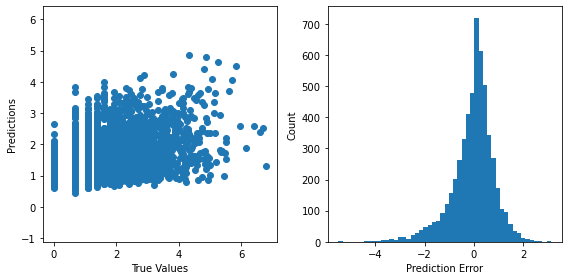

In [63]:
# Visualizing ensemble of tuned XGB models, with another XGB model trained on their predictions
plot_prediction(y_val, ensemble_2_preds)

# Model Evaluation
We've done some pretty deep NLP and machine learning analysis on our data - what are our findings? What is our best performing model, and how does it perform on our holdout data?

In [528]:
# Checking prediction R2 with target
print('Sorted models, scored on R2:')
pd.DataFrame(predictions.join(pd.DataFrame(y_val).reset_index(drop=True))
             .corr()['retweets']
             .sort_values(ascending=False))**2

Sorted models, scored on R2:


,retweets
retweets,1.000000
XGB_baseline,0.212288
linreg_baseline,0.199123
linreg_ensemble_baseline,0.180404
linreg_emb_baseline,0.102371
linreg_meta_baseline,0.077366
linreg_bow_baseline,0.063152
linreg_top_baseline,0.024053


It looks like forecasting from our metadata - the follower count and list count of tweeting accounts - still beats our Natural Language Processing methods. And that's not a huge surprise! It makes sense that follower count contains a lot of data about how often something is retweeted. Our models that contain this metadata consistently outperform our models that don't, and typically models with more features diluted this predictive power. Our model based on followers and lists alone accounted for 27.8% of the variance in retweet count.

Our best performing NLP model was a tuned XGB on document embeddings. Document embeddings provide deep, high-dimensional vectors about our text content. Exploring further in this direction may be the next step for natural language processing.

Also, somewhat unexpectedly, our hyperparameter tuning was not very effective on our data. This may be because the default XGB values work well for high numbers of features, or some other strange interaction.

XGB and Linear Regression outperformed TabNet on our validation data. This was surprising to me, as I had high hopes for TabNet. Deep learning with dense networks and 1D CNNs were also tried, but their performance was worse than tabnet, and at some point were cut from the analysis.

Taking a batch of model predictions and feeding them into another model usually performed better than just taking the mean of those predictions. This was cool to see in practice.

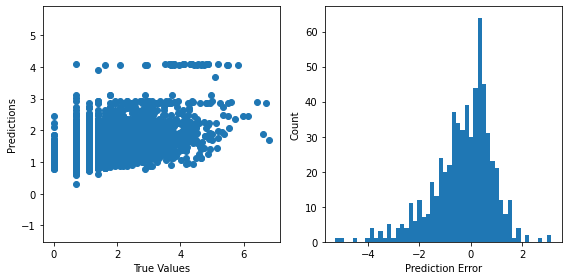

In [301]:
# Distribution of predictions and true values
plot_prediction(y_val, predictions['XGB_metadata_baseline']) # val_meta_pred, val_emb_pred, val_emb_pred, val_top_pred

## Testing on Holdout Data

In [421]:
# NLP Prediction from document embeddings - expected to be the least accurate
document_embeddings_test_predictions = XGB4.predict(X_test.filter(regex='_EMB')) # Prediction

doc_emb_log_rmse = round(np.sqrt(MSE(y_test, document_embeddings_test_predictions)), 4)
doc_emb_rmse = round(np.sqrt(MSE((np.exp(y_test) - 1), np.exp(document_embeddings_test_predictions) - 1)), 4)
doc_emb_r2 = round(pd.DataFrame(document_embeddings_test_predictions).join(y_test.reset_index(drop=True)).corr()['retweets'][0]**2, 4)

print('Document Embeddings log RMSE: ', doc_emb_log_rmse) # RMSE
print('Document Embeddings RMSE: ', doc_emb_rmse)
print('Document Embeddings R2: ', doc_emb_r2)

Document Embeddings log RMSE:  0.9107
Document Embeddings RMSE:  23.6174
Document Embeddings R2:  0.1056


In [422]:
# Our ensemble prediction - Possibly more robust
final_preds = pd.DataFrame(XGB_meta.predict(X_test[['followers', 'lists']])).rename({0:'meta'}, axis=1)
final_preds = final_preds.join(pd.DataFrame(XGB_bow.predict(X_test.filter(regex='_BOW')))).rename({0:'bow'}, axis=1)
final_preds = final_preds.join(pd.DataFrame(XGB_emb.predict(X_test.filter(regex='_EMB')))).rename({0:'emb'}, axis=1)
final_preds = final_preds.join(pd.DataFrame(XGB_top.predict(X_test.filter(regex='_TOP')))).rename({0:'top'}, axis=1)

final_ensemble = final_preds.mean(axis=1) # Taking the mean

fin_ens_log_rmse = round(np.sqrt(MSE(y_test, final_ensemble)), 4)
fin_ens_rmse = round(np.sqrt(MSE((np.exp(y_test) - 1), np.exp(final_ensemble) - 1)), 4)
fin_ens_r2 = round(pd.DataFrame(final_ensemble).join(y_test.reset_index(drop=True)).corr()['retweets'][0]**2, 4)

print("Final Ensemble log RMSE : ", fin_ens_log_rmse) # RMSE
print('Final Ensemble RMSE: ', fin_ens_rmse)
print('Final ensemble R2: ', fin_ens_r2)

Final Ensemble log RMSE :  0.871
Final Ensemble RMSE:  23.3141
Final ensemble R2:  0.2605


In [423]:
# Prediction from Account Info - expected to be most accurate
metadata_test_predictions = XGB6.predict(X_test[['followers', 'lists']]) # Prediction

meta_log_rmse = round(np.sqrt(MSE(y_test, metadata_test_predictions)), 4)
meta_rmse = round(np.sqrt(MSE((np.exp(y_test) - 1), np.exp(metadata_test_predictions) - 1)), 4)
meta_r2 = round(pd.DataFrame(metadata_test_predictions).join(y_test.reset_index(drop=True)).corr()['retweets'][0]**2, 4)

print('Account Info log RMSE: ', meta_log_rmse) # RMSE
print('Account Info RMSE: ', meta_rmse)
print('Account Info R2: ', meta_r2)

Account Info log RMSE:  0.8239
Account Info RMSE:  22.3162
Account Info R2:  0.2678


# Findings
Here we can see that our models perform comparably on our holdout data as on our validation data. Our most accurate indicator is still predicting retweet frequency from account information, accounts that have more followers are more likely to get retweeted, and this relationship explains about 28% of the variance on its own.

Looking at document embeddings, we can explain roughly another 10-11% of the variance. In practice, ensembling these predictions to build a more accurate model is nontrivial, and neither taking the mean nor feeding ensemble predictions into another layer of machine learning were able to beat account metadata for predictive power.

In [448]:
# Making some dataframes from top models for graphs
model_names = {0:'Document Embeddings', 1:'XGB Ensemble', 2:'MetaData'}
log_rmse_tests = pd.DataFrame([doc_emb_log_rmse, fin_ens_log_rmse, meta_log_rmse]).rename(model_names).rename({0:'log_RMSE'}, axis=1)
rmse_tests = pd.DataFrame([doc_emb_rmse, fin_ens_rmse, meta_rmse]).rename(model_names).rename({0:'RMSE'}, axis=1)
r2_tests = pd.DataFrame([doc_emb_r2, fin_ens_r2, meta_r2]).rename(model_names).rename({0:'R2'}, axis=1)

<Figure size 720x576 with 0 Axes>

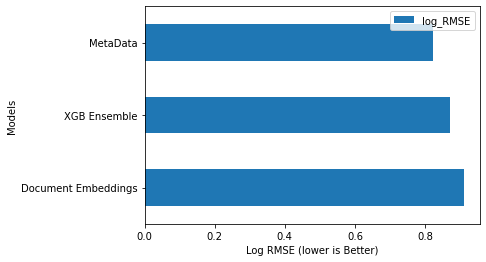

<Figure size 720x576 with 0 Axes>

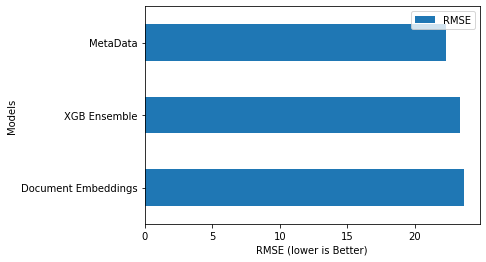

<Figure size 720x576 with 0 Axes>

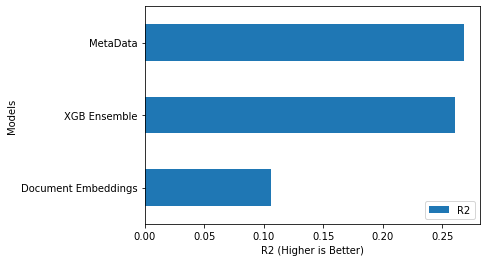

In [525]:
# Graph of log RMSE
plt.figure(figsize=(10, 8))
(log_rmse_tests).plot.barh();
plt.xlabel('Log RMSE (lower is Better)')
plt.ylabel('Models');
plt.show()

# Graph of RMSE
plt.figure(figsize=(10, 8))
(rmse_tests).plot.barh()
plt.xlabel('RMSE (lower is Better)')
plt.ylabel('Models')
plt.show()

# Graph of r2
plt.figure(figsize=(10, 8))
(r2_tests).plot.barh()
plt.xlabel('R2 (Higher is Better)')
plt.ylabel('Models')
plt.show()

# Conclusions
Being able to explain 10% of virality based on text alone is still useful, and building that into copywriting, social media management, or communications dashboards would be a useful reference. Communication on the whole is complicated and very high dimensional, but the existence of our relatively simple models consistently describing some amount of information propagation rate provides a useful reference.

Virality is a hard thing to predict, partly because, like the stock market, once people find a strategy that consistently works, it influences the information landscape and eventually stops working. This evolving information landscape leads to the need for constantly shifting communication strategies. This means any model trained on language will probably decay in accuracy, depending on the rate of cultural change. This has some interesting ramifications, and means you can't just predict what has worked, but also what will work at the time of posting. It doesn't currently seem possible to have a predictive model with anywhere near the level of resolution needed to predict future trends, but it may be an interesting experiment if you have access to enough data.

More work was done that was cut from this notebook - All of the deep learning besides tabnet were removed, as well as random forest regression, as in each case they consistently underperformed our other options. For brevity I moved their coding blocks into a scratch-code notebook which I can share upon request.

### Next Steps
The next steps for predicting virality fall into a few categories:
- integrating with users, for example through a dashboard where people can input text to get a virality score
- Improving the quality of our predictive models, either through collecting more data or more sophisticated NLP
- mapping out our graph of actors and ties and interpreting the predictive power of the network itself
- studying the structure of various feeds and interpreting how information is selected and shown
- finding the right way to ensemble our current predictive power

Areas that are not likely to yield further gains:
- machine learning algorithms don't seem likely to see significant improvement on the current data through hyperparameter tuning
- Deep learning still seems to struggle with tabular data, and we still need something better than TabNet for this kind of task


# The End :)

For more information or contract work, reach out to me at:
- blakemcme@gmail.com
- github.com/thegrandblooms
- linkedin.com/in/blakemcme